In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

## We start by training a feed forward neural net on the MNIST data, for a baseline 

In [2]:
# Now we download the MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

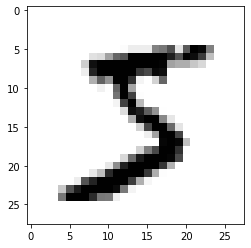

In [3]:
plt.imshow(x_train[0], cmap=plt.cm.binary)
x_train = tf.keras.utils.normalize(x_train, axis=1)
x_test = tf.keras.utils.normalize(x_test, axis=1)

In [4]:
# Next we define a feedforward neural net model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten()) # this is the input layer
# Now for our hidden layers
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu)) # 128 neurons, with ReLU activation
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu)) # 128 neurons, with ReLU activation
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax)) # final layer with 10 neurons, with softmax activation

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model.fit(x_train, y_train, epochs=3)

Train on 60000 samples
Epoch 1/3
60000/60000 [==============================] - 9s 154us/sample - loss: 0.2615 - accuracy: 0.9238
Epoch 2/3
60000/60000 [==============================] - 8s 136us/sample - loss: 0.1088 - accuracy: 0.9668
Epoch 3/3
60000/60000 [==============================] - 8s 136us/sample - loss: 0.0741 - accuracy: 0.9766


In [5]:
val_loss, val_acc = model.evaluate(x_test, y_test, verbose=0);
predictions = model.predict([x_test]) #takes a list

print(predictions) # these are one_hot arrays of probability distributions, use numpy

[[1.8350710e-09 1.4208547e-08 2.1304224e-06 ... 9.9991381e-01
  1.0387985e-07 6.0644152e-06]
 [7.0073201e-09 2.7004434e-03 9.9715579e-01 ... 2.1988400e-09
  2.5990030e-06 3.7059720e-11]
 [9.6867083e-09 9.9994051e-01 1.1829853e-05 ... 3.6729762e-05
  4.6452228e-06 1.4078607e-07]
 ...
 [5.8660754e-10 3.1308273e-06 9.2491540e-08 ... 5.2604947e-04
  3.1802549e-06 1.0070178e-04]
 [8.2932547e-07 2.1091513e-07 1.2455999e-07 ... 6.0222845e-07
  1.7571646e-04 9.3221066e-09]
 [5.0834143e-07 1.1318653e-07 5.6452893e-07 ... 8.4745752e-11
  4.9750287e-07 3.7788670e-08]]


7


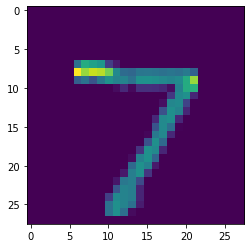

In [6]:
# Now we check if it has worked on just the first image
print(np.argmax(predictions[0]))
plt.imshow(x_test[0])

## Now we modify the CNN code to work with Keras

We begin by giving the data an 80/20 split between training and testing. 

This neural net has 2 convolutional layers with 5 by 5 filters in each and all activations are ReLU. We also include a softmax output layer with a fully connected layer at the end.

We optimize using the Adam optimizer and dropout for the first dense layer. 

In [7]:
# load train and test dataset
def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = mnist.load_data()
    # reshape dataset to have a single channel
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    # one hot encode target values
    trainY = keras.utils.to_categorical(trainY)
    testY = keras.utils.to_categorical(testY)
    return trainX, trainY, testX, testY
 
# define cnn model
def define_model():
    model = tf.keras.models.Sequential()
    model.add(layers.Conv2D(32, (5, 5), input_shape=(28, 28, 1)) )
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (5, 5)))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(.2, input_shape=(1024,)) )
    model.add(layers.Activation('relu'))
    
    model.add(layers.Dense(10))
    model.add(layers.Activation('softmax'))
    # compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    return model

In [8]:
trainX, trainY, testX, testY = load_dataset()
CNN_model = define_model()
CNN_model.summary()

history = CNN_model.fit(trainX, trainY, epochs=8, batch_size=32, validation_split=0.2, verbose=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 32)        832       
_________________________________________________________________
activation (Activation)      (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
activation_1 (Activation)    (None, 8, 8, 64)          0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)             

In [11]:
history
#CNN_model.save('final_model.h5')
#CNN_model = load_model('final_model.h5')

# evaluate model on test dataset
_, acc = CNN_model.evaluate(testX, testY, verbose=0)
print('Accuracy percentage on testing data: ', (acc * 100.0))

Accuracy percentage on testing data:  98.29999804496765


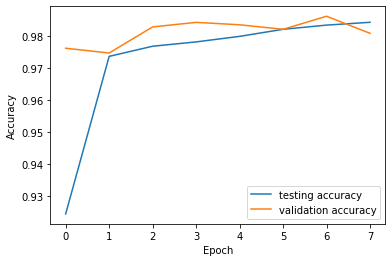

In [12]:
plt.plot(history.history['accuracy'], label='testing accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
#plt.savefig('MNIST_CNN.pdf')

## We modify the CNN to use same padding and batch normalization

In [13]:
CNN2 = tf.keras.models.Sequential()
CNN2.add(layers.Conv2D(32, (3, 3), padding='same', input_shape=(28, 28, 1)) )
CNN2.add(layers.Activation('relu'))
CNN2.add(layers.BatchNormalization(  ) )
CNN2.add(layers.MaxPooling2D((2, 2)))
CNN2.add(layers.Conv2D(32, (3, 3), padding='same'))
CNN2.add(layers.Activation('relu'))
CNN2.add(layers.BatchNormalization(  ) )
CNN2.add(layers.MaxPooling2D((2, 2)))
CNN2.add(layers.Flatten())
CNN2.add(layers.Dropout(.2, input_shape=(1024,)) )
CNN2.add(layers.Activation('relu'))
    
CNN2.add(layers.Dense(10))
CNN2.add(layers.Activation('softmax'))
# compile model
CNN2.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [14]:
CNN2.summary()

history = CNN2.fit(trainX, trainY, epochs=8, batch_size=32, validation_split=0.2, verbose=1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
activation_4 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
activation_5 (Activation)    (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 32)       

Accuracy percentage on testing data:  99.15000200271606


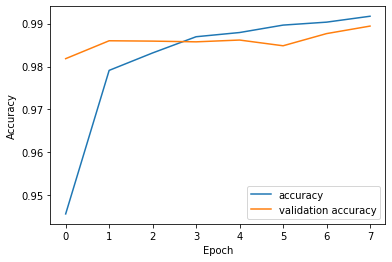

In [15]:
_, acc = CNN2.evaluate(testX, testY, verbose=0)
print('Accuracy percentage on testing data: ', (acc * 100.0))

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
#plt.savefig('MNIST_CNN2.pdf')

## LSTM with the IMDB dataset

In [13]:
from tensorflow.keras.datasets import imdb

In [14]:
(x_train_imdb, y_train_imdb), (x_test_imdb, y_test_imdb) = imdb.load_data(path="imdb.npz",num_words=5000)

In [15]:
x_train_imdb = keras.preprocessing.sequence.pad_sequences(x_train_imdb, maxlen=500)
x_test_imdb = keras.preprocessing.sequence.pad_sequences(x_test_imdb, maxlen=500)

In [16]:
lstm_model = keras.models.Sequential()
lstm_model.add(layers.Embedding(5000, 32))
lstm_model.add(layers.LSTM(32, return_sequences=True))
lstm_model.add(layers.Dense(1))
lstm_model.add(layers.Activation('sigmoid'))

lstm_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          160000    
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           33        
_________________________________________________________________
activation_2 (Activation)    (None, None, 1)           0         
Total params: 168,353
Trainable params: 168,353
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm_model.fit(x_train_imdb, y_train_imdb, batch_size=100, epochs=10)#, validation_data=(x_test_imdb, y_test_imdb))
score, acc = lstm_model.evaluate(x_test_imdb, y_test_imdb, batch_size=32)
print('Test score:', score)
print('Test accuracy:', acc)

Train on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 293s 12ms/sample - loss: 0.6308 - accuracy: 0.5907
Epoch 2/10
25000/25000 [==============================] - 293s 12ms/sample - loss: 0.5672 - accuracy: 0.6383
Epoch 3/10
25000/25000 [==============================] - 260s 10ms/sample - loss: 0.5596 - accuracy: 0.6417
Epoch 4/10
25000/25000 [==============================] - 248s 10ms/sample - loss: 0.5424 - accuracy: 0.6553
Epoch 5/10
25000/25000 [==============================] - 272s 11ms/sample - loss: 0.5408 - accuracy: 0.6528
Epoch 6/10
25000/25000 [==============================] - 249s 10ms/sample - loss: 0.5291 - accuracy: 0.6604
Epoch 7/10
 1900/25000 [=>............................] - ETA: 4:15 - loss: 0.5168 - accuracy: 0.6710

# Here we build our table to collect the results of the LSTM validation error


| Hidden states     |  Embed length: 8  |   16     | 32      |  
| :---        |    :----:  |         :---: | :---:        | 
| 16      | .6480       | .6549   | .6595      | 
| 32   | .6526        | .6610      | .6604   | 
| 64   | .6438        | .6565      | .6585   | 
| 128   | .6495        | .6537      | .6566   | 
| Table of  out-of-sample accuracies |